In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers import Adam
from keras import utils
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/ColabNotebooks/DepressionDetection/models/")
from utils import read_conv, prep_conv_data

In [ ]:
dir_path = "/content/drive/MyDrive/ColabNotebooks/DepressionDetection/models/"
file_path = os.path.join(dir_path, "utils.py")

# Check if the path and file exist
print("Directory exists:", os.path.exists(dir_path))
print("File exists:", os.path.exists(file_path))


Directory exists: True
File exists: True


In [ ]:
file_path = "/content/drive/MyDrive/ColabNotebooks/DepressionDetection/outputs/columns_to_remove.json"
with open(file_path, 'r') as f:
    cols_to_remove = json.load(f)
print(*cols_to_remove[:5], sep='\n')

F0semitoneFrom27.5Hz_sma3nz_amean
F0semitoneFrom27.5Hz_sma3nz_percentile80.0
F0semitoneFrom27.5Hz_sma3nz_percentile20.0
F0semitoneFrom27.5Hz_sma3nz_percentile50.0
loudness_sma3_percentile50.0


In [ ]:
df_dict , max_rows, num_features = read_conv(train=True, cols_to_remove=cols_to_remove)
features, depression_labels, gender_labels = prep_conv_data(df_dict, max_rows, num_features)

Removing null values present in spk_402.csv


In [ ]:
# define and train CNN Model
utils.set_random_seed(3)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), padding = "same", use_bias = True, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                           input_shape=(max_rows, num_features, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (2, 2),  padding = "same",use_bias = True,strides = (1,1),activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding = "same", use_bias = True,
                            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 378, 61, 32)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 189, 30, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 30, 64)       8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 94, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 15, 64)        16448     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 47, 7, 64)         0

In [ ]:
history = model.fit(features, depression_labels, epochs=100, batch_size=16, validation_split=0.15)

Epoch 1/100
5/5 [==============================] - 1s 107ms/step - loss: 13.1927 - accuracy: 0.5068 - val_loss: 1.5243 - val_accuracy: 0.7857
Epoch 2/100
5/5 [==============================] - 0s 83ms/step - loss: 17.6413 - accuracy: 0.5753 - val_loss: 1.6617 - val_accuracy: 0.8571
Epoch 3/100
5/5 [==============================] - 0s 78ms/step - loss: 15.7907 - accuracy: 0.6164 - val_loss: 1.7035 - val_accuracy: 0.8571
Epoch 4/100
5/5 [==============================] - 0s 79ms/step - loss: 15.5713 - accuracy: 0.6027 - val_loss: 1.6371 - val_accuracy: 0.7857
Epoch 5/100
5/5 [==============================] - 0s 77ms/step - loss: 11.8824 - accuracy: 0.5890 - val_loss: 1.6675 - val_accuracy: 0.7857
Epoch 6/100
5/5 [==============================] - 0s 91ms/step - loss: 15.6417 - accuracy: 0.6027 - val_loss: 1.7055 - val_accuracy: 0.7857
Epoch 7/100
5/5 [==============================] - 0s 79ms/step - loss: 12.2061 - accuracy: 0.5479 - val_loss: 1.7453 - val_accuracy: 0.7143
Epoch 8/100


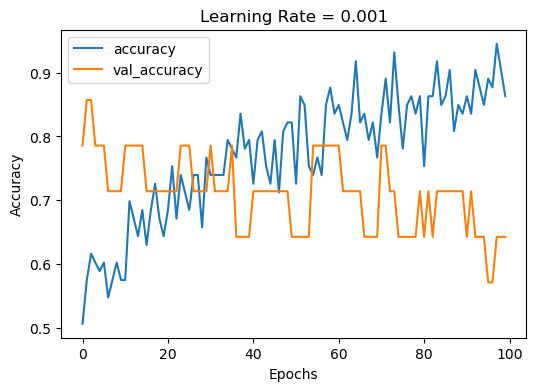

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
test_df_dict , _, _ = read_conv(train=False, cols_to_remove=cols_to_remove)
test_features, test_depression_labels, test_gender_labels = prep_conv_data(test_df_dict, max_rows, num_features)

In [ ]:
test_loss, test_acc = model.evaluate(test_features,  test_depression_labels)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

1/1 [==============================] - 0s 39ms/step - loss: 1.4904 - accuracy: 0.7500
Test loss:  1.4904026985168457
Test accuracy:  0.75


1/1 [==============================] - 0s 77ms/step
Classification Report 
               precision    recall  f1-score   support

         0.0       0.74      1.00      0.85        14
         1.0       1.00      0.17      0.29         6

    accuracy                           0.75        20
   macro avg       0.87      0.58      0.57        20
weighted avg       0.82      0.75      0.68        20



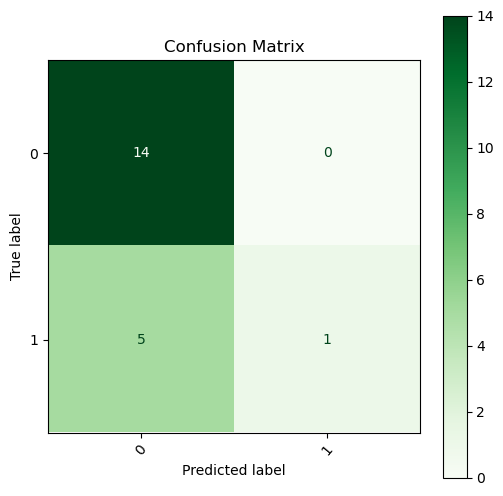

In [ ]:
#Making predictions for the test set with the CNN model from b)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(test_features)
y_pred_classes = np.where(y_pred>0.5,1,0)

print("Classification Report \n", classification_report(test_depression_labels, y_pred_classes))

#Visualizing the confusion matrix
conf_matrix = confusion_matrix(test_depression_labels, y_pred_classes)
plt.rcParams['figure.figsize'] = (6, 6)
display_c_m = ConfusionMatrixDisplay(conf_matrix)
display_c_m.plot(cmap='Greens', xticks_rotation=50)
plt.title('Confusion Matrix')
plt.show()

# Perform Depression classification on n selected features

In [ ]:
selection = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DepressionDetection/outputs/correlation.csv")
selection.head()

,features,d_corr,d_fisher,g_corr,g_fisher
0,F0semitoneFrom27.5Hz_sma3nz_amean,0.107491,0.028664,-0.576537,1.001286
1,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,0.004798,0.000057,0.005656,0.000068
2,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.108764,0.029254,-0.585239,1.036141
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.110978,0.030454,-0.586118,1.050623
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.104159,0.026888,-0.561804,0.933077


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DepressionDetection/data/train_data_final.csv")
test_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DepressionDetection/data/test_data_final.csv")
train_df.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,Participant_ID,Depression,Gender
0,33.883310,0.188470,31.197649,31.198807,31.237043,0.039394,39.990345,28.040092,100.798780,0.000000,...,1.960784,2.061856,0.240000,0.010000,0.225,0.005000,-53.529380,448,1,1
1,23.442284,0.015231,23.083265,23.519197,23.799660,0.716394,0.000000,0.000000,-0.109734,0.000000,...,3.703704,2.040816,0.080000,0.000000,0.380,0.000000,-47.326970,448,1,1
2,26.658195,0.095594,24.275490,27.404346,29.017082,4.741592,61.829530,67.673560,20.461290,11.705440,...,3.131991,2.036199,0.344444,0.235472,0.115,0.087321,-41.121784,448,1,1
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.333334,0.000000,0.000000,0.000000,0.240,0.000000,-56.265000,448,1,1
4,34.614662,0.005980,34.433628,34.559757,34.764160,0.330532,8.279264,5.828207,8.208370,6.596444,...,5.084746,1.886793,0.420000,0.000000,0.040,0.020000,-33.531155,448,1,1


## Test Pearson's Correlation filter method

In [ ]:
  # # obtain training dataset
  # y_train = train_df["Depression"].values
  # x_train = train_df[n_sorted]
  # train_male = train_df[train_df["Gender"] == 1].index
  # train_female = t3rain_df[train_df["Gender"] == 0].index

  # # obtain testing dataset
  # y_test = test_df["Depression"].values
  # x_test = test_df[n_sorted]
  # test_male = test_df[test_df["Gender"] == 1].index
  # test_female = test_df[test_df["Gender"] == 0].index

  # # normalize features
  # scaler = StandardScaler()
  # x_train_scaled = scaler.fit_transform(x_train)
  # x_test_scaled = scaler.transform(x_test)

  # # reshape training dataset to fit CNN requirements
  # x_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], 1, x_train_scaled.shape[1], 1)
  # x_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1], 1)
  # print(x_train_reshaped.shape)

In [ ]:
corr_sorted = selection["d_corr"].sort_values(ascending=False)
features_sorted = selection.iloc[corr_sorted.index]["features"]

n_features_list = [5, 10, 15, 20, 25, 30]
Bacc = []
acc = []

for n in n_features_list:
  # remove the features that aren't selected
  n_sorted = features_sorted[:n].values
  columns_to_remove = [feature for feature in features_sorted if feature not in n_sorted]

  # prepare the training data
  train_df , max_rows, n_features = read_conv(train=True, cols_to_remove=columns_to_remove)
  features, labels, _ = prep_conv_data(train_df, max_rows, n_features)

  print(max_rows)
  print(n_features)

  # prepare the test data
  test_df , _, _ = read_conv(train=False, cols_to_remove=columns_to_remove)
  test_features, test_labels, _ = prep_conv_data(test_df, max_rows, n_features)

  # update the model
  utils.set_random_seed(3)
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (2, 2), padding = "same", use_bias = True, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                            input_shape=(max_rows, n_features, 1)),
      tf.keras.layers.MaxPooling2D((2, 2)),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (2, 2),  padding = "same",use_bias = True,strides = (1,1),activation='relu',
                            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding = "same", use_bias = True,
                              kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.8),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # # compile and train the CNN
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(features, labels, epochs=100, batch_size=16, validation_split=0.15)

  # # predict labels on test dataset
  pred_labels = model.predict(test_features)
  pred_labels = np.where(pred_labels > 0.5, 1, 0)

  # # printing confusion matrix
  conf_matrix = confusion_matrix(test_labels, pred_labels)
  plt.rcParams['figure.figsize'] = (6, 6)
  display_c_m = ConfusionMatrixDisplay(conf_matrix)
  display_c_m.plot(cmap='Greens', xticks_rotation=50)
  plt.title('Confusion Matrix')
  plt.show()

  # calc accuracy
  test_acc = np.mean(pred_labels == test_labels)

  # calc balanced accuracy
  y_test_ones = (test_labels == 1)
  y_test_zeros = (test_labels == 0)
  correct_ones = (pred_labels[y_test_ones] == 1).sum()
  correct_zeros = (pred_labels[y_test_zeros] == 0).sum()
  test_Bacc = 0.5 * (correct_ones / y_test_ones.sum()) + 0.5 * (correct_zeros / y_test_zeros.sum())


  acc.append(test_acc)
  Bacc.append(test_Bacc)

In [ ]:
print(acc)
print(n_features_list)
print(Bacc)

[0.75, 0.65, 0.7, 0.55, 0.6, 0.55]
[5, 10, 15, 20, 25, 30]
[0.6785714285714286, 0.5595238095238095, 0.5476190476190477, 0.44047619047619047, 0.47619047619047616, 0.44047619047619047]


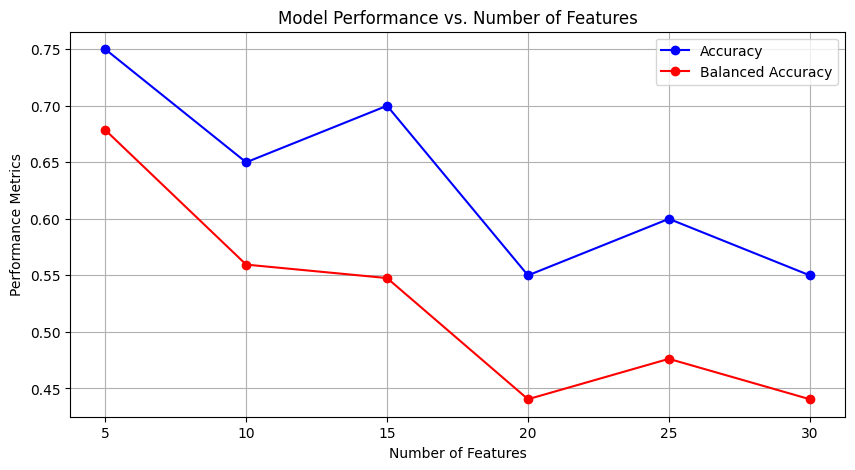

In [ ]:
plt.figure(figsize=(10, 5))  # Set the figure size for better readability

# Plot accuracy
plt.plot(n_features_list, acc, label='Accuracy', marker='o', linestyle='-', color='b')

# Plot balanced accuracy
plt.plot(n_features_list, Bacc, label='Balanced Accuracy', marker='o', linestyle='-', color='r')

# Adding titles and labels
plt.title('Model Performance vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Performance Metrics')
plt.xticks(n_features_list)  # Ensure all feature counts are marked

# Adding a legend to clarify the lines
plt.legend()

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.show()


# Feature Selection with Fisher's Score

In [ ]:
fish_sorted = selection["d_fisher"].sort_values(ascending=False)
features_sorted = selection.iloc[fish_sorted.index]["features"]

n_features_list = [5, 10, 15, 20, 25, 30]
Bacc = []
acc = []
EO = []

for n in n_features_list:
  # remove the features that aren't selected
  n_sorted = features_sorted[:n].values
  columns_to_remove = [feature for feature in features_sorted if feature not in n_sorted]

  # prepare the training data
  train_df , max_rows, n_features = read_conv(train=True, cols_to_remove=columns_to_remove)
  features, depression_labels, gender_labels = prep_conv_data(train_df, max_rows, n_features)

  print(max_rows)
  print(n_features)

  # prepare the test data
  test_df , _, _ = read_conv(train=False, cols_to_remove=columns_to_remove)
  test_features, test_depression_labels, test_gender_labels = prep_conv_data(test_df, max_rows, n_features)

  # update the model
  utils.set_random_seed(3)
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (2, 2), padding = "same", use_bias = True, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                            input_shape=(max_rows, n_features, 1)),
      tf.keras.layers.MaxPooling2D((2, 2)),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (2, 2),  padding = "same",use_bias = True,strides = (1,1),activation='relu',
                            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding = "same", use_bias = True,
                              kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.8),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # # compile and train the CNN
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(features, depression_labels, epochs=100, batch_size=16, validation_split=0.15)

  # # predict labels on test dataset
  pred_labels = model.predict(test_features)
  pred_labels = np.where(pred_labels > 0.5, 1, 0)

  # calc true positive rates
  female_labels = (test_gender_labels == 0)
  # actual_dep_f = (test_depression_labels[female_labels] == 1)
  # pred_dep_f = (pred_labels[female_labels] == 1)

  # TPR_f = recall_score(actual_dep_f, pred_dep_f)

  male_labels = (test_gender_labels == 1)
  # actual_dep_m = (test_depression_labels[male_labels] == 1)
  # pred_dep_m = (pred_labels[male_labels] == 1)

  # TPR_m = recall_score(actual_dep_m, pred_dep_m)

  # # calc equality of opportunity (EO)
  # test_EO = 1 - abs(TPR_m - TPR_f)


  # Calculate True Positive Rates using sklearn's recall_score
  TPR_f = recall_score(test_depression_labels[female_labels], pred_labels[female_labels])
  TPR_m = recall_score(test_depression_labels[male_labels], pred_labels[male_labels])

  # Calculate Equality of Opportunity (EO)
  EO_score = 1 - abs(TPR_m - TPR_f)

  # Store the calculated EO
  EO.append(EO_score)

  # calc accuracy
  test_acc = np.mean(pred_labels == test_depression_labels)

  # calc balanced accuracy
  y_test_ones = (test_depression_labels == 1)
  y_test_zeros = (test_depression_labels == 0)
  correct_ones = (pred_labels[y_test_ones] == 1).sum()
  correct_zeros = (pred_labels[y_test_zeros] == 0).sum()
  test_Bacc = 0.5 * (correct_ones / y_test_ones.sum()) + 0.5 * (correct_zeros / y_test_zeros.sum())


  acc.append(test_acc)
  Bacc.append(test_Bacc)

Removing null values present in spk_402.csv
386
5
Epoch 1/100
5/5 [==============================] - 2s 61ms/step - loss: 0.7823 - accuracy: 0.7260 - val_loss: 0.7591 - val_accuracy: 0.6429
Epoch 2/100
5/5 [==============================] - 0s 13ms/step - loss: 0.7519 - accuracy: 0.7397 - val_loss: 0.7422 - val_accuracy: 0.6429
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 0.7382 - accuracy: 0.7397 - val_loss: 0.7434 - val_accuracy: 0.6429
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 0.7057 - accuracy: 0.7397 - val_loss: 0.7277 - val_accuracy: 0.6429
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6893 - accuracy: 0.7397 - val_loss: 0.7207 - val_accuracy: 0.6429
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 0.6646 - accuracy: 0.7397 - val_loss: 0.7203 - val_accuracy: 0.6429
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 0.6074 - accuracy: 0.7397 - val_loss: 

[0.7, 0.7, 0.7, 0.65, 0.7, 0.65]
[0.5952380952380952, 0.5952380952380952, 0.5952380952380952, 0.5595238095238095, 0.6428571428571428, 0.5119047619047619]
[0.6, 0.6, 0.6, 0.6, 0.4, 0.8]


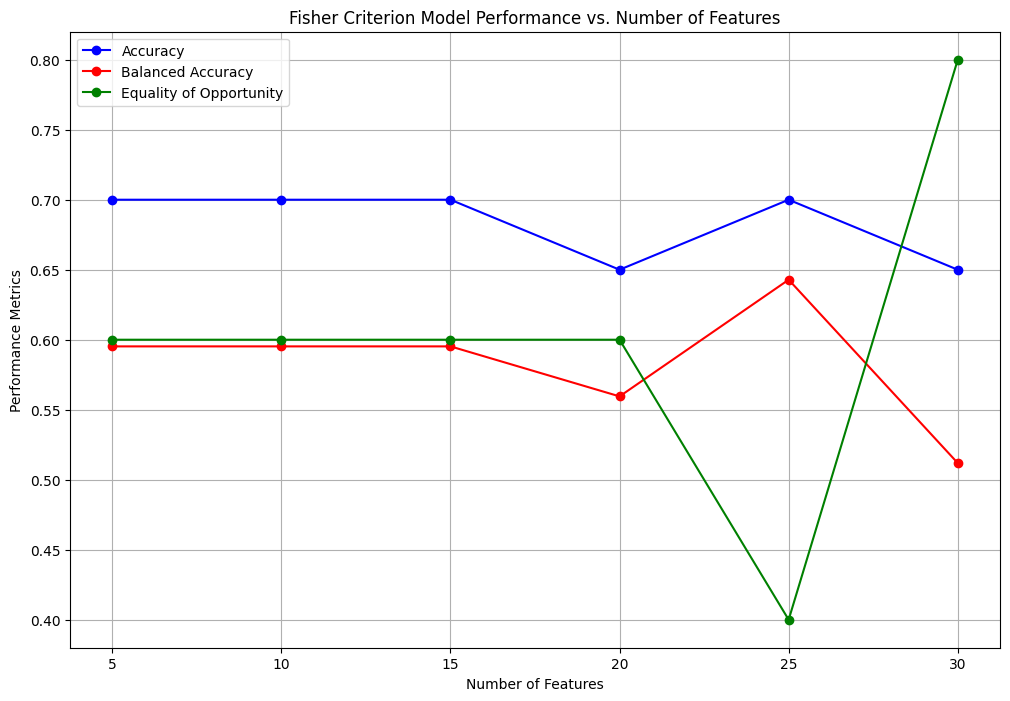

In [ ]:
print(acc)
print(Bacc)
print(EO)

plt.figure(figsize=(12, 8))  # Set the figure size for better readability

# Plot accuracy
plt.plot(n_features_list, acc, label='Accuracy', marker='o', linestyle='-', color='b')

# Plot balanced accuracy
plt.plot(n_features_list, Bacc, label='Balanced Accuracy', marker='o', linestyle='-', color='r')

plt.plot(n_features_list, EO, label="Equality of Opportunity", marker='o', linestyle='-', color='g')

# Adding titles and labels
plt.title('Fisher Criterion Model Performance vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Performance Metrics')
plt.xticks(n_features_list)  # Ensure all feature counts are marked

# Adding a legend to clarify the lines
plt.legend()

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.show()

# Feature Selection for Gender Classification

In [ ]:
fish_sorted = selection["g_fisher"].sort_values(ascending=False)
features_sorted = selection.iloc[fish_sorted.index]["features"]

n_features_list = [5, 10, 15, 20, 25, 30]
gender_features = []
Bacc = []
acc = []
EO = []

for n in n_features_list:
  # remove the features that aren't selected
  n_sorted = features_sorted[:n].values
  columns_to_remove = [feature for feature in features_sorted if feature not in n_sorted]

  gender_features.append(n_sorted)

  # prepare the training data
  train_df , max_rows, n_features = read_conv(train=True, cols_to_remove=columns_to_remove)
  features, depression_labels, gender_labels = prep_conv_data(train_df, max_rows, n_features)

  print(max_rows)
  print(n_features)

  # prepare the test data
  test_df , _, _ = read_conv(train=False, cols_to_remove=columns_to_remove)
  test_features, test_depression_labels, test_gender_labels = prep_conv_data(test_df, max_rows, n_features)

  # update the model
  utils.set_random_seed(3)
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (2, 2), padding = "same", use_bias = True, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                            input_shape=(max_rows, n_features, 1)),
      tf.keras.layers.MaxPooling2D((2, 2)),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (2, 2),  padding = "same",use_bias = True,strides = (1,1),activation='relu',
                            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
      # tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding = "same", use_bias = True,
                              kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.8),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # # compile and train the CNN
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(features, gender_labels, epochs=100, batch_size=16, validation_split=0.15)

  # # predict labels on test dataset
  pred_labels = model.predict(test_features)
  pred_labels = np.where(pred_labels > 0.5, 1, 0)

  # # calc true positive rates
  # female_labels = (test_gender_labels == 0)
  # actual_dep_f = test_depression_labels[female_labels] == 1
  # pred_dep_f = (pred_labels[female_labels] == 1)

  # TPR_f = recall_score(pred_dep_f, actual_dep_f)

  # male_labels = (test_gender_labels == 1)
  # actual_dep_m = (test_depression_labels[male_labels] == 1)
  # pred_dep_m = (pred_labels[male_labels] == 1)

  # TPR_m = recall_score(pred_dep_m, actual_dep_m)

  # # calc equality of opportunity (EO)
  # test_EO = 1 - abs(TPR_m - TPR_f)

  # calc accuracy
  test_acc = np.mean(pred_labels == test_gender_labels)

  # calc balanced accuracy
  y_test_ones = (test_gender_labels == 1)
  y_test_zeros = (test_gender_labels == 0)
  correct_ones = (pred_labels[y_test_ones] == 1).sum()
  correct_zeros = (pred_labels[y_test_zeros] == 0).sum()
  test_Bacc = 0.5 * (correct_ones / y_test_ones.sum()) + 0.5 * (correct_zeros / y_test_zeros.sum())


  acc.append(test_acc)
  Bacc.append(test_Bacc)
  EO.append(test_EO)

Removing null values present in spk_402.csv
378
5
Epoch 1/100
5/5 [==============================] - 3s 77ms/step - loss: 1.1953 - accuracy: 0.4658 - val_loss: 0.7755 - val_accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 1.1895 - accuracy: 0.5068 - val_loss: 0.8564 - val_accuracy: 0.5000
Epoch 3/100
5/5 [==============================] - 0s 21ms/step - loss: 0.8220 - accuracy: 0.5753 - val_loss: 0.8076 - val_accuracy: 0.5000
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 0.7391 - accuracy: 0.6986 - val_loss: 0.7725 - val_accuracy: 0.5714
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 0.7104 - accuracy: 0.6986 - val_loss: 0.7603 - val_accuracy: 0.6429
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 0.7258 - accuracy: 0.6575 - val_loss: 0.7386 - val_accuracy: 0.5714
Epoch 7/100
5/5 [==============================] - 0s 15ms/step - loss: 0.7036 - accuracy: 0.6301 - val_loss: 

[0.65, 0.7, 0.9, 0.75, 0.65, 0.65]
[0.6041666666666667, 0.6458333333333333, 0.8958333333333333, 0.7291666666666667, 0.6041666666666667, 0.625]


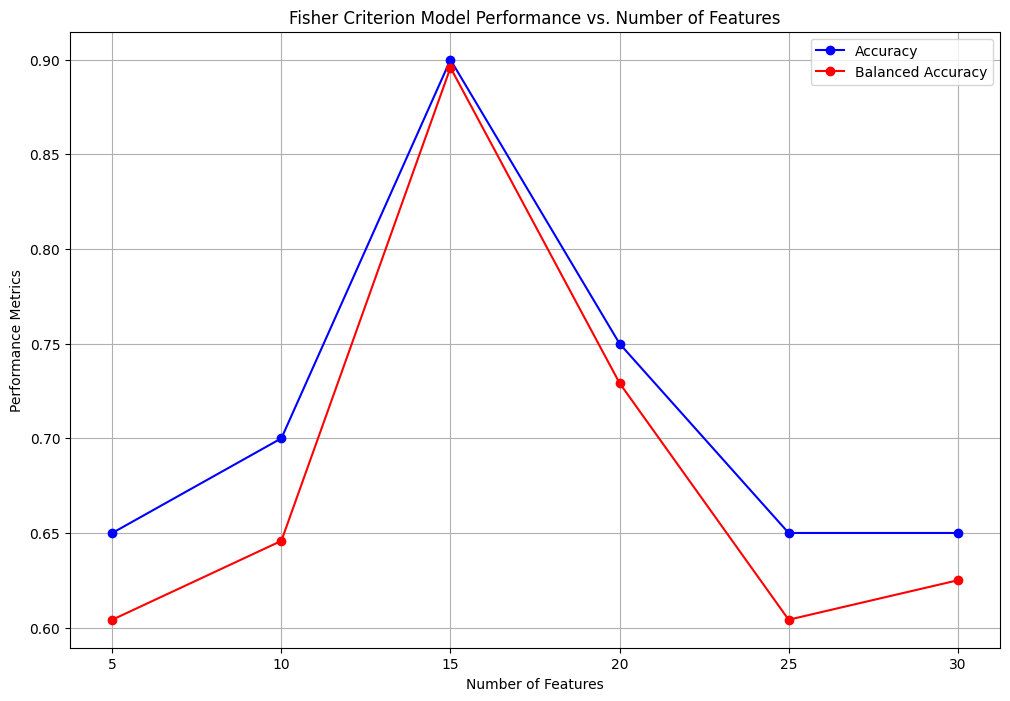

In [ ]:
print(acc)
print(Bacc)
# print(EO)

plt.figure(figsize=(12, 8))  # Set the figure size for better readability

# Plot accuracy
plt.plot(n_features_list, acc, label='Accuracy', marker='o', linestyle='-', color='b')

# Plot balanced accuracy
plt.plot(n_features_list, Bacc, label='Balanced Accuracy', marker='o', linestyle='-', color='r')

# plt.plot(n_features_list, EO, label="Equality of Opportunity", marker='o', linestyle='-', color='g')

# Adding titles and labels
plt.title('Fisher Criterion Model Performance vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Performance Metrics')
plt.xticks(n_features_list)  # Ensure all feature counts are marked

# Adding a legend to clarify the lines
plt.legend()

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
fish_sorted = selection["g_fisher"].sort_values(ascending=False)
features_sorted = selection.iloc[fish_sorted.index]["features"]

n_features_list = [5, 10, 15, 20, 25, 30]
gender_features = []
Bacc = []
acc = []
EO = []

for n in n_features_list:
  # remove the features that aren't selected
  n_sorted = features_sorted[:n].values
  gender_features.append(n_sorted)

In [ ]:
print(gender_features[2])

['HNRdBACF_sma3nz_amean' 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0'
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'
 'F0semitoneFrom27.5Hz_sma3nz_amean' 'slopeV0-500_sma3nz_amean'
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0' 'mfcc4V_sma3nz_amean'
 'mfcc4_sma3_amean' 'jitterLocal_sma3nz_stddevNorm'
 'F1frequency_sma3nz_stddevNorm' 'mfcc3V_sma3nz_amean'
 'slopeUV0-500_sma3nz_amean' 'mfcc3_sma3_amean'
 'shimmerLocaldB_sma3nz_stddevNorm' 'F2frequency_sma3nz_stddevNorm']


In [ ]:

# prepare the training data
train_df , max_rows, n_features = read_conv(train=True, cols_to_remove=gender_features[2])
features, depression_labels, gender_labels = prep_conv_data(train_df, max_rows, n_features)

print(max_rows)
print(n_features)

# prepare the test data
test_df , _, _ = read_conv(train=False, cols_to_remove=gender_features[2])
test_features, test_depression_labels, test_gender_labels = prep_conv_data(test_df, max_rows, n_features)

# update the model
utils.set_random_seed(3)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), padding = "same", use_bias = True, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                          input_shape=(max_rows, n_features, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (2, 2),  padding = "same",use_bias = True,strides = (1,1),activation='relu',
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding = "same", use_bias = True,
                            kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# # compile and train the CNN
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(features, depression_labels, epochs=100, batch_size=16, validation_split=0.15)

# # predict labels on test dataset
pred_labels = model.predict(test_features)
pred_labels = np.where(pred_labels > 0.5, 1, 0)

# calc true positive rates
female_labels = (test_gender_labels == 0)
male_labels = (test_gender_labels == 1)

# Calculate True Positive Rates using sklearn's recall_score
TPR_f = recall_score(test_depression_labels[female_labels], pred_labels[female_labels])
TPR_m = recall_score(test_depression_labels[male_labels], pred_labels[male_labels])

# Calculate Equality of Opportunity (EO)
EO_score = 1 - abs(TPR_m - TPR_f)

# calc accuracy
test_acc = np.mean(pred_labels == test_depression_labels)

# calc balanced accuracy
y_test_ones = (test_depression_labels == 1)
y_test_zeros = (test_depression_labels == 0)
correct_ones = (pred_labels[y_test_ones] == 1).sum()
correct_zeros = (pred_labels[y_test_zeros] == 0).sum()
test_Bacc = 0.5 * (correct_ones / y_test_ones.sum()) + 0.5 * (correct_zeros / y_test_zeros.sum())

print("Accuracy for removing gender-dependant features: ", test_acc)
print("Balanced accuracy for removing gender-dependant features: ", test_Bacc)
print("EO for removing gender-dependant features: ", EO_score)

Removing null values present in spk_402.csv
378
73
Epoch 1/100
5/5 [==============================] - 5s 298ms/step - loss: 110.9383 - accuracy: 0.4658 - val_loss: 136.7857 - val_accuracy: 0.6429
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 78.0861 - accuracy: 0.6849 - val_loss: 22.7374 - val_accuracy: 0.5714
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 16.5419 - accuracy: 0.5342 - val_loss: 17.7491 - val_accuracy: 0.5714
Epoch 4/100
5/5 [==============================] - 0s 23ms/step - loss: 3.4994 - accuracy: 0.7397 - val_loss: 17.1702 - val_accuracy: 0.5714
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 2.7906 - accuracy: 0.8219 - val_loss: 15.9117 - val_accuracy: 0.5714
Epoch 6/100
5/5 [==============================] - 0s 23ms/step - loss: 2.1548 - accuracy: 0.7671 - val_loss: 14.8967 - val_accuracy: 0.5714
Epoch 7/100
5/5 [==============================] - 0s 22ms/step - loss: 2.3520 - accuracy: 0.8082

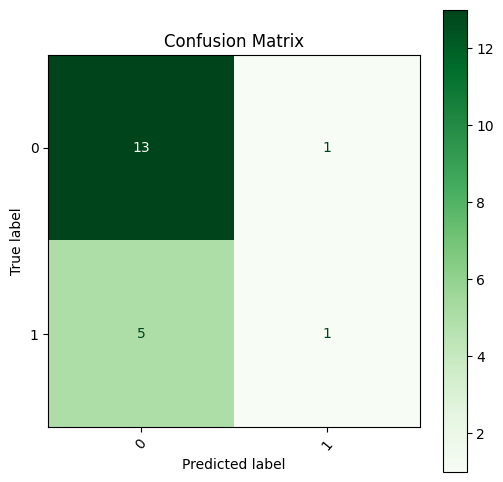

In [ ]:
#Making predictions for the test set with the CNN model from b)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Visualizing the confusion matrix
conf_matrix = confusion_matrix(test_depression_labels, pred_labels)
plt.rcParams['figure.figsize'] = (6, 6)
display_c_m = ConfusionMatrixDisplay(conf_matrix)
display_c_m.plot(cmap='Greens', xticks_rotation=50)
plt.title('Confusion Matrix')
plt.show()